In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5869471083950083 	 Validation loss: 0.4209633227122032 	 
  1%|          | 574/57400 [01:40<2:42:57,  5.81it/s]
Epoch 2 	 Training loss: 0.38951044646497385 	 Validation loss: 0.3525593154511209 	 
  2%|▏         | 1148/57400 [03:23<2:34:46,  6.06it/s]
Epoch 3 	 Training loss: 0.345861555495744 	 Validation loss: 0.3347808986397113 	 
  3%|▎         | 1722/57400 [05:02<2:26:26,  6.34it/s]
Epoch 4 	 Training loss: 0.3247812163954413 	 Validation loss: 0.32535276549347375 	 
  4%|▍         | 2296/57400 [06:39<2:14:53,  6.81it/s]
Epoch 5 	 Training loss: 0.3088747972447282 	 Validation loss: 0.31921210657742066 	 
  5%|▌         | 2870/57400 [08:16<2:26:20,  6.21it/s]
Epoch 6 	 Training loss: 0.2938718576672185 	 Validation loss: 0.31294315649291216 	 
  6%|▌         | 3444/57400 [09:52<2:23:34,  6.26it/s]
Epoch 7 	 Training loss: 0.28586785998909314 	 Validation loss: 0.3078113534187866 	 
  7%|▋         | 4018/57400 [11:29<2:19:54,  6.36it/s]
Epoch 8 	 Trainin

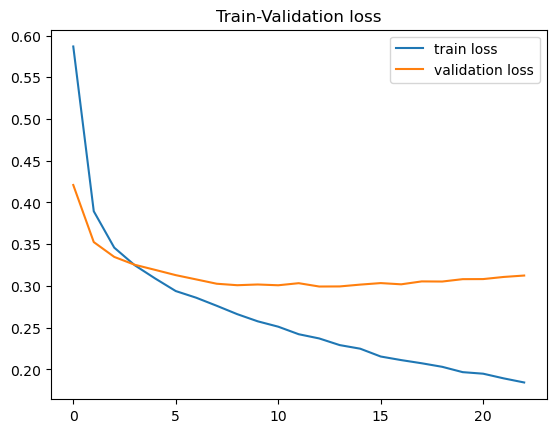

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8545918367346939, 'precision': 0.8545918367346939, 'f1': 0.8545918367346939, 'accuracy': 0.8545918367346939}
MALE {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
FEMALE {'recall': 0.8525, 'precision': 0.8525, 'f1': 0.8525, 'accuracy': 0.8525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6881313131313131, 'precision': 0.6881313131313131, 'f1': 0.6881313131313131, 'accuracy': 0.6881313131313131}
MALE {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}
FEMALE {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6844850065189049, 'precision': 0.6844850065189049, 'f1': 0.6844850065189049, 'accuracy': 0.6844850065189049}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5606101083630884 	 Validation loss: 0.3965736051737252 	 
  1%|          | 574/57400 [01:34<2:35:03,  6.11it/s]
Epoch 2 	 Training loss: 0.37552687003948965 	 Validation loss: 0.3485661846096233 	 
  2%|▏         | 1148/57400 [03:09<2:30:18,  6.24it/s]
Epoch 3 	 Training loss: 0.3405186656979318 	 Validation loss: 0.3326627672728846 	 
  3%|▎         | 1722/57400 [04:44<2:34:11,  6.02it/s]
Epoch 4 	 Training loss: 0.32129665910678457 	 Validation loss: 0.3237766661381317 	 
  4%|▍         | 2296/57400 [06:18<2:25:13,  6.32it/s]
Epoch 5 	 Training loss: 0.3049843433322807 	 Validation loss: 0.31882004136756315 	 
  5%|▌         | 2870/57400 [07:53<2:26:04,  6.22it/s]
Epoch 6 	 Training loss: 0.29396186275764624 	 Validation loss: 0.3155409971536216 	 
  6%|▌         | 3444/57400 [09:28<2:25:50,  6.17it/s]
Epoch 7 	 Training loss: 0.279731263682402 	 Validation loss: 0.3080743993237867 	 
  7%|▋         | 4018/57400 [11:03<2:25:06,  6.13it/s]
Epoch 8 	 Training

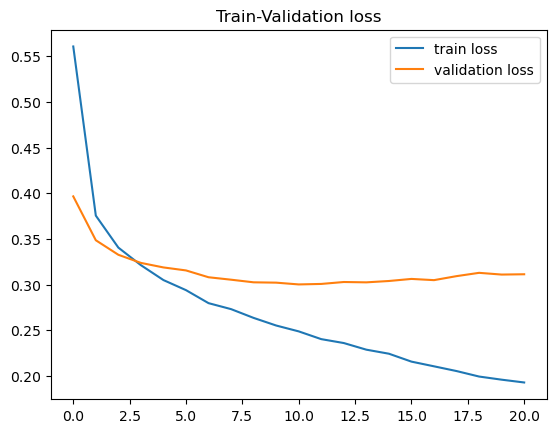

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}
MALE {'recall': 0.8645833333333334, 'precision': 0.8645833333333334, 'f1': 0.8645833333333333, 'accuracy': 0.8645833333333334}
FEMALE {'recall': 0.8275, 'precision': 0.8275, 'f1': 0.8275, 'accuracy': 0.8275} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6755050505050505, 'precision': 0.6755050505050505, 'f1': 0.6755050505050505, 'accuracy': 0.6755050505050505}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6857887874837028, 'precision': 0.6857887874837028, 'f1': 0.6857887874837028, 'accuracy': 0.6857887874837028}
MALE {'recall': 0.70

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5887638915602754 	 Validation loss: 0.4312262843220921 	 
  1%|          | 574/57400 [01:34<2:24:48,  6.54it/s]
Epoch 2 	 Training loss: 0.39248983780058416 	 Validation loss: 0.362102047366611 	 
  2%|▏         | 1148/57400 [03:09<2:27:04,  6.37it/s]
Epoch 3 	 Training loss: 0.3481114381333677 	 Validation loss: 0.3398119549630052 	 
  3%|▎         | 1722/57400 [04:43<2:25:49,  6.36it/s]
Epoch 4 	 Training loss: 0.3257483881525046 	 Validation loss: 0.3297720329236176 	 
  4%|▍         | 2296/57400 [06:18<2:32:02,  6.04it/s]
Epoch 5 	 Training loss: 0.3112687474239994 	 Validation loss: 0.3197931417469251 	 
  5%|▌         | 2870/57400 [07:53<2:20:13,  6.48it/s]
Epoch 6 	 Training loss: 0.2968640348740986 	 Validation loss: 0.31691624880847286 	 
  6%|▌         | 3444/57400 [09:28<2:18:06,  6.51it/s]
Epoch 7 	 Training loss: 0.2858613099163002 	 Validation loss: 0.311463820732246 	 
  7%|▋         | 4018/57400 [11:02<2:19:47,  6.36it/s]
Epoch 8 	 Training lo

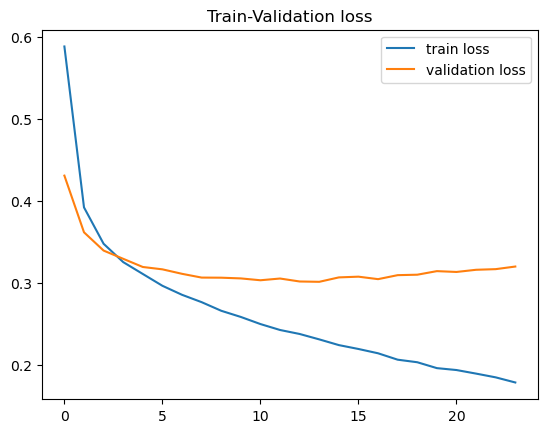

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8596938775510204, 'precision': 0.8596938775510204, 'f1': 0.8596938775510204, 'accuracy': 0.8596938775510204}
MALE {'recall': 0.8776041666666666, 'precision': 0.8776041666666666, 'f1': 0.8776041666666666, 'accuracy': 0.8776041666666666}
FEMALE {'recall': 0.8425, 'precision': 0.8425, 'f1': 0.8425, 'accuracy': 0.8425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6742424242424242, 'precision': 0.6742424242424242, 'f1': 0.6742424242424242, 'accuracy': 0.6742424242424242}
MALE {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6857887874837028, 'precision': 0.6857887874837028, 'f1': 0.6857887874837028, 'accuracy': 0.6857887874837028}
MALE {'recall': 

Resultados finales

In [23]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8533163265306123, 'precision': 0.8533163265306123, 'f1': 0.8533163265306123, 'accuracy': 0.8533163265306123}
Métricas etiqueta male: {'recall': 0.8663194444444444, 'precision': 0.8663194444444444, 'f1': 0.8663194444444444, 'accuracy': 0.8663194444444444}
Métricas etiqueta female:  {'recall': 0.8408333333333333, 'precision': 0.8408333333333333, 'f1': 0.8408333333333333, 'accuracy': 0.8408333333333333}

 to
Resultado global: {'recall': 0.6792929292929293, 'precision': 0.6792929292929293, 'f1': 0.6792929292929293, 'accuracy': 0.6792929292929293}
Métricas etiqueta male: {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}
Métricas etiqueta female:  {'recall': 0.6509186351706037, 'precision': 0.6509186351706037, 'f1': 0.6509186351706037, 'accuracy': 0.6509186351706037}

 as
Resultado global: {'recall': 0.6853541938287702, 'precision': 0.6853541938287702, 'f1': 0.6

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958830862302814 	 Validation loss: 0.6940864961026079 	 
  1%|          | 574/57400 [01:35<2:31:08,  6.27it/s]
Epoch 2 	 Training loss: 0.6947056380090814 	 Validation loss: 0.6936455379098149 	 
  2%|▏         | 1148/57400 [03:10<2:30:36,  6.23it/s]
Epoch 3 	 Training loss: 0.6949628340242632 	 Validation loss: 0.6938945246955096 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:46<2:17:22,  6.76it/s]
Epoch 4 	 Training loss: 0.6945062705448696 	 Validation loss: 0.6947913786112252 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:20<2:27:29,  6.23it/s]
Epoch 5 	 Training loss: 0.6945693498081447 	 Validation loss: 0.693090964171846 	 
  5%|▌         | 2870/57400 [07:56<2:27:26,  6.16it/s]
Epoch 6 	 Training loss: 0.6942522462444438 	 Validation loss: 0.6927424285371425 	 
  6%|▌         | 3444/57400 [09:31<2:25:05,  6.20it/s]
Epoch 7 	 Training loss: 0.6946009510693234 	 Validation loss: 0.6935862312882634 	 

1 epoch without im

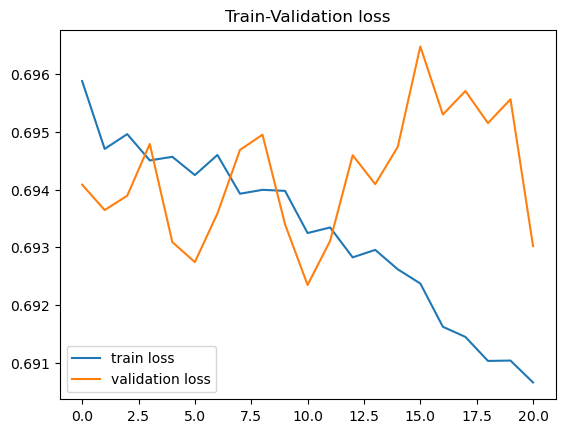

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5790816326530612, 'precision': 0.5790816326530612, 'f1': 0.5790816326530612, 'accuracy': 0.5790816326530612}
MALE {'recall': 0.4869791666666667, 'precision': 0.4869791666666667, 'f1': 0.4869791666666667, 'accuracy': 0.4869791666666667}
FEMALE {'recall': 0.6675, 'precision': 0.6675, 'f1': 0.6675, 'accuracy': 0.6675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}
MALE {'recall': 0.45742092457420924, 'precision': 0.45742092457420924, 'f1': 0.45742092457420924, 'accuracy': 0.45742092457420924}
FEMALE {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5371577574967406, 'precision': 0.5371577574967406, 'f1': 0.5371577574967406, 'accuracy': 0.5371577574967406}
MALE {'recal

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970958523841685 	 Validation loss: 0.6930932331893404 	 
  1%|          | 574/57400 [01:35<2:33:46,  6.16it/s]
Epoch 2 	 Training loss: 0.6953369367621086 	 Validation loss: 0.6936112601878279 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:10<2:32:27,  6.15it/s]
Epoch 3 	 Training loss: 0.6946742387183452 	 Validation loss: 0.6924224263530666 	 
  3%|▎         | 1722/57400 [04:46<2:11:22,  7.06it/s]
Epoch 4 	 Training loss: 0.6946906421450373 	 Validation loss: 0.6932803614664886 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:21<2:25:40,  6.30it/s]
Epoch 5 	 Training loss: 0.6937244377692817 	 Validation loss: 0.6931665590253927 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [07:56<2:23:12,  6.35it/s]
Epoch 6 	 Training loss: 0.6939433128783927 	 Validation loss: 0.6935622803235458 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:31<2:21:15,  6.37it/s]
Epoch 7 	 Training loss: 0.6937889120304626 	

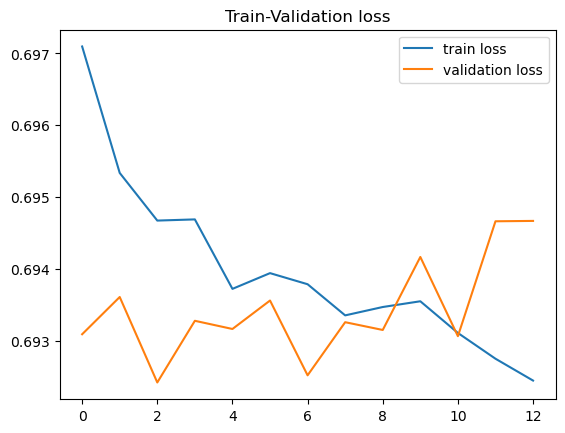

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5637755102040817, 'precision': 0.5637755102040817, 'f1': 0.5637755102040817, 'accuracy': 0.5637755102040817}
MALE {'recall': 0.5026041666666666, 'precision': 0.5026041666666666, 'f1': 0.5026041666666666, 'accuracy': 0.5026041666666666}
FEMALE {'recall': 0.6225, 'precision': 0.6225, 'f1': 0.6225, 'accuracy': 0.6225} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5391414141414141, 'precision': 0.5391414141414141, 'f1': 0.5391414141414141, 'accuracy': 0.5391414141414141}
MALE {'recall': 0.45012165450121655, 'precision': 0.45012165450121655, 'f1': 0.45012165450121655, 'accuracy': 0.45012165450121655}
FEMALE {'recall': 0.6351706036745407, 'precision': 0.6351706036745407, 'f1': 0.6351706036745407, 'accuracy': 0.6351706036745407} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5554106910039114, 'precision': 0.5554106910039114, 'f1': 0.5554106910039114, 'accuracy': 0.5554106910039114}
MALE {'recal

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963874807756537 	 Validation loss: 0.6939935108362618 	 
  1%|          | 574/57400 [01:35<2:34:29,  6.13it/s]
Epoch 2 	 Training loss: 0.6944975372183199 	 Validation loss: 0.6941143930968592 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:10<2:29:39,  6.26it/s]
Epoch 3 	 Training loss: 0.6940473704387917 	 Validation loss: 0.6941330008587595 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:44<2:26:10,  6.35it/s]
Epoch 4 	 Training loss: 0.6938013722049234 	 Validation loss: 0.6929842637757123 	 
  4%|▍         | 2296/57400 [06:20<2:22:21,  6.45it/s]
Epoch 5 	 Training loss: 0.6936571827541245 	 Validation loss: 0.6941782316919101 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:55<2:25:57,  6.23it/s]
Epoch 6 	 Training loss: 0.6933376498338653 	 Validation loss: 0.6921753519672459 	 
  6%|▌         | 3444/57400 [09:30<2:20:34,  6.40it/s]
Epoch 7 	 Training loss: 0.6929903517409068 	 Validation loss: 0.694072317

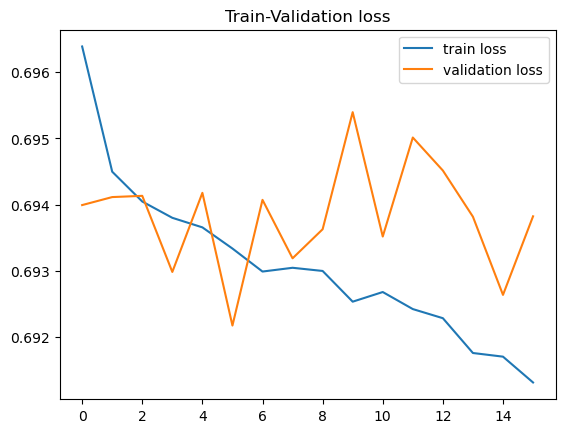

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5344387755102041, 'precision': 0.5344387755102041, 'f1': 0.5344387755102041, 'accuracy': 0.5344387755102041}
MALE {'recall': 0.21614583333333334, 'precision': 0.21614583333333334, 'f1': 0.21614583333333331, 'accuracy': 0.21614583333333334}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
MALE {'recall': 0.1654501216545012, 'precision': 0.1654501216545012, 'f1': 0.1654501216545012, 'accuracy': 0.1654501216545012}
FEMALE {'recall': 0.863517060367454, 'precision': 0.863517060367454, 'f1': 0.863517060367454, 'accuracy': 0.863517060367454} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5071707953063885, 'precision': 0.5071707953063885, 'f1': 0.5071707953063885, 'accuracy': 0.5071707953063885}
MALE {'rec

Resultados finales

In [31]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5590986394557823, 'precision': 0.5590986394557823, 'f1': 0.5590986394557823, 'accuracy': 0.5590986394557823}
Métricas etiqueta male: {'recall': 0.4019097222222222, 'precision': 0.4019097222222222, 'f1': 0.4019097222222222, 'accuracy': 0.4019097222222222}
Métricas etiqueta female:  {'recall': 0.71, 'precision': 0.71, 'f1': 0.71, 'accuracy': 0.71}

 to
Resultado global: {'recall': 0.5332491582491583, 'precision': 0.5332491582491583, 'f1': 0.5332491582491583, 'accuracy': 0.5332491582491583}
Métricas etiqueta male: {'recall': 0.35766423357664234, 'precision': 0.35766423357664234, 'f1': 0.35766423357664234, 'accuracy': 0.35766423357664234}
Métricas etiqueta female:  {'recall': 0.7226596675415573, 'precision': 0.7226596675415573, 'f1': 0.7226596675415573, 'accuracy': 0.7226596675415573}

 as
Resultado global: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
Mét

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952173716099835 	 Validation loss: 0.6940716666690374 	 
  1%|          | 574/57400 [01:35<2:32:48,  6.20it/s]
Epoch 2 	 Training loss: 0.6939893267295917 	 Validation loss: 0.6939159793368841 	 
  2%|▏         | 1148/57400 [03:10<2:35:05,  6.04it/s]
Epoch 3 	 Training loss: 0.6925808620162126 	 Validation loss: 0.6933488067934068 	 
  3%|▎         | 1722/57400 [04:46<2:24:31,  6.42it/s]
Epoch 4 	 Training loss: 0.6914360611488595 	 Validation loss: 0.692017656261638 	 
  4%|▍         | 2296/57400 [06:22<2:25:24,  6.32it/s]
Epoch 5 	 Training loss: 0.6899751507862104 	 Validation loss: 0.6921298796847716 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:57<2:22:22,  6.38it/s]
Epoch 6 	 Training loss: 0.6893100162208703 	 Validation loss: 0.694238889015327 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:32<2:25:18,  6.19it/s]
Epoch 7 	 Training loss: 0.6881598389937903 	 Validation loss: 0.6910873419147426 	 
  7%|▋         | 401

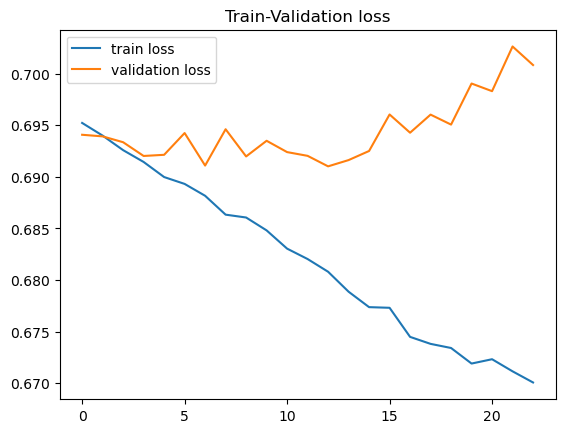

In [33]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6020408163265306, 'precision': 0.6020408163265306, 'f1': 0.6020408163265306, 'accuracy': 0.6020408163265306}
MALE {'recall': 0.6432291666666666, 'precision': 0.6432291666666666, 'f1': 0.6432291666666666, 'accuracy': 0.6432291666666666}
FEMALE {'recall': 0.5625, 'precision': 0.5625, 'f1': 0.5625, 'accuracy': 0.5625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6325757575757576, 'precision': 0.6325757575757576, 'f1': 0.6325757575757576, 'accuracy': 0.6325757575757576}
MALE {'recall': 0.7274939172749392, 'precision': 0.7274939172749392, 'f1': 0.7274939172749392, 'accuracy': 0.7274939172749392}
FEMALE {'recall': 0.5301837270341208, 'precision': 0.5301837270341208, 'f1': 0.5301837270341208, 'accuracy': 0.5301837270341208} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6897001303780965, 'precision': 0.6897001303780965, 'f1': 0.6897001303780965, 'accuracy': 0.6897001303780965}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938742722160725 	 Validation loss: 0.6927936875214011 	 
  1%|          | 574/57400 [01:35<2:13:45,  7.08it/s]
Epoch 2 	 Training loss: 0.6931997607186281 	 Validation loss: 0.6913463675369651 	 
  2%|▏         | 1148/57400 [03:10<2:24:36,  6.48it/s]
Epoch 3 	 Training loss: 0.6918378808772523 	 Validation loss: 0.690308690071106 	 
  3%|▎         | 1722/57400 [04:46<2:26:13,  6.35it/s]
Epoch 4 	 Training loss: 0.6901129639937903 	 Validation loss: 0.6901963312747115 	 
  4%|▍         | 2296/57400 [06:21<2:31:33,  6.06it/s]
Epoch 5 	 Training loss: 0.6889023211774926 	 Validation loss: 0.6902037919577906 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:56<2:37:31,  5.77it/s]
Epoch 6 	 Training loss: 0.6877419701436671 	 Validation loss: 0.6916688508906607 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:31<2:25:27,  6.18it/s]
Epoch 7 	 Training loss: 0.6864710503131255 	 Validation loss: 0.6918106836787725 	 

3 epoch without im

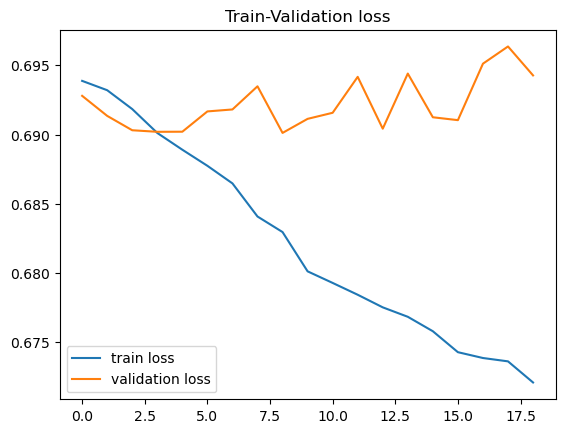

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6785714285714286, 'precision': 0.6785714285714286, 'f1': 0.6785714285714286, 'accuracy': 0.6785714285714286}
MALE {'recall': 0.6614583333333334, 'precision': 0.6614583333333334, 'f1': 0.6614583333333334, 'accuracy': 0.6614583333333334}
FEMALE {'recall': 0.695, 'precision': 0.695, 'f1': 0.695, 'accuracy': 0.695} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6830808080808081, 'precision': 0.6830808080808081, 'f1': 0.6830808080808081, 'accuracy': 0.6830808080808081}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7392438070404173, 'precision': 0.7392438070404173, 'f1': 0.7392438070404173, 'accuracy': 0.7392438070404173}
MALE {'recall': 0.719696

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6957630641784402 	 Validation loss: 0.6928700137946565 	 
  1%|          | 574/57400 [01:35<2:28:24,  6.38it/s]
Epoch 2 	 Training loss: 0.6932794930419856 	 Validation loss: 0.69261843370179 	 
  2%|▏         | 1148/57400 [03:10<2:29:22,  6.28it/s]
Epoch 3 	 Training loss: 0.6921179164785126 	 Validation loss: 0.6945894764641584 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:45<2:28:07,  6.26it/s]
Epoch 4 	 Training loss: 0.6903781523272551 	 Validation loss: 0.6907618167036671 	 
  4%|▍         | 2296/57400 [06:21<2:28:53,  6.17it/s]
Epoch 5 	 Training loss: 0.6889362015375277 	 Validation loss: 0.6935620732226614 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:56<2:30:55,  6.02it/s]
Epoch 6 	 Training loss: 0.6879416101900958 	 Validation loss: 0.6911657583915581 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:31<2:31:52,  5.92it/s]
Epoch 7 	 Training loss: 0.686753880167672 	 Validation loss: 0.692334997451

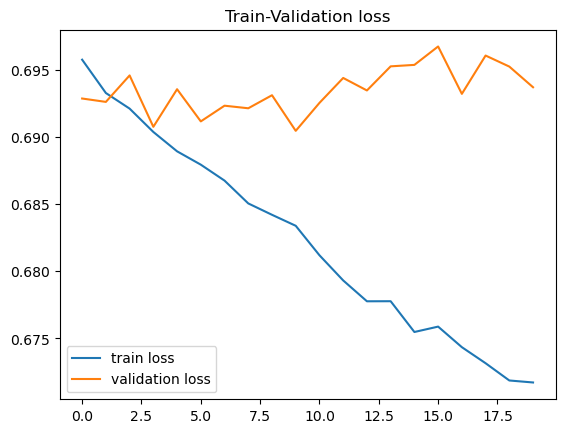

In [37]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_abs_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [38]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6492346938775511, 'precision': 0.6492346938775511, 'f1': 0.6492346938775511, 'accuracy': 0.6492346938775511}
MALE {'recall': 0.6927083333333334, 'precision': 0.6927083333333334, 'f1': 0.6927083333333334, 'accuracy': 0.6927083333333334}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6805555555555556, 'precision': 0.6805555555555556, 'f1': 0.6805555555555556, 'accuracy': 0.6805555555555556}
MALE {'recall': 0.7274939172749392, 'precision': 0.7274939172749392, 'f1': 0.7274939172749392, 'accuracy': 0.7274939172749392}
FEMALE {'recall': 0.6299212598425197, 'precision': 0.6299212598425197, 'f1': 0.6299212598425197, 'accuracy': 0.6299212598425197} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7262059973924381, 'precision': 0.7262059973924381, 'f1': 0.7262059973924381, 'accuracy': 0.7262059973924381}
MALE {'recall': 

Resultados finales

In [39]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6432823129251701, 'precision': 0.6432823129251701, 'f1': 0.6432823129251701, 'accuracy': 0.6432823129251701}
Métricas etiqueta male: {'recall': 0.6657986111111112, 'precision': 0.6657986111111112, 'f1': 0.6657986111111112, 'accuracy': 0.6657986111111112}
Métricas etiqueta female:  {'recall': 0.6216666666666667, 'precision': 0.6216666666666667, 'f1': 0.6216666666666667, 'accuracy': 0.6216666666666667}

 to
Resultado global: {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}
Métricas etiqueta male: {'recall': 0.7210056772100568, 'precision': 0.7210056772100568, 'f1': 0.7210056772100568, 'accuracy': 0.7210056772100568}
Métricas etiqueta female:  {'recall': 0.605424321959755, 'precision': 0.605424321959755, 'f1': 0.605424321959755, 'accuracy': 0.605424321959755}

 as
Resultado global: {'recall': 0.7183833116036507, 'precision': 0.7183833116036507, 'f1': 0.71838